In [1]:
from fastbook import *
from fastai.vision.widgets import *
import os

First, we inspect the path at which our dataset on dog breeds is available.

In [2]:
data_path = '/mnt/data/data_science/dog_imgs'
os.listdir(data_path)

['Norfolk_terrier', 'bloodhound', 'beagle', 'miniature_schnauzer', 'basset']

We see that there are 5 directories, where each directory contains images for 1 dog breed. Our task will be to train a deep learning model to classify images based on their breed. First, we load all the images from our dogs directory:

In [5]:
dogs = get_image_files(data_path)
dogs

(#883) [Path('/mnt/data/data_science/dog_imgs/Norfolk_terrier/n02094114_1498.jpg'),Path('/mnt/data/data_science/dog_imgs/Norfolk_terrier/n02094114_1852.jpg'),Path('/mnt/data/data_science/dog_imgs/Norfolk_terrier/n02094114_1416.jpg'),Path('/mnt/data/data_science/dog_imgs/Norfolk_terrier/n02094114_1610.jpg'),Path('/mnt/data/data_science/dog_imgs/Norfolk_terrier/n02094114_1505.jpg'),Path('/mnt/data/data_science/dog_imgs/Norfolk_terrier/n02094114_113.jpg'),Path('/mnt/data/data_science/dog_imgs/Norfolk_terrier/n02094114_2129.jpg'),Path('/mnt/data/data_science/dog_imgs/Norfolk_terrier/n02094114_2454.jpg'),Path('/mnt/data/data_science/dog_imgs/Norfolk_terrier/n02094114_4127.jpg'),Path('/mnt/data/data_science/dog_imgs/Norfolk_terrier/n02094114_947.jpg')...]

Now, we check to see if any of the images are corrupted or will not be able to be used.

In [6]:
failed_dog_imgs = verify_images(dogs)

In [7]:
failed_dog_imgs

(#0) []

Great, so we have no failed images. Now, lets create the data loader for our dog images. I am going to start by just cropping the images to 128 size, but in later sections I'll compare some different methods.

In [32]:
dog_dl = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dog_dat = dog_dl.dataloaders(data_path)

We can see below how the cropping creates bad images. Look at how that beagles face got chopped off.

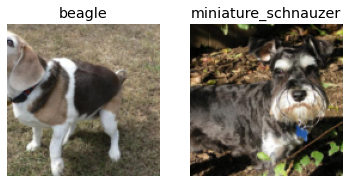

In [33]:
dog_dat.valid.show_batch(max_n = 2)

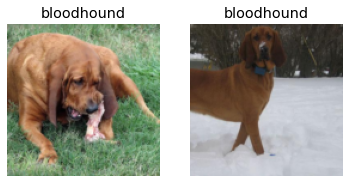

In [34]:
dog_dat.train.show_batch(max_n = 2)

I would like to count the number of cases in each set (training and validation) by the outcome class (dog breed), just to make sure the function did create a good balance:

In [22]:
dog_dat

I am going to create an augmented data set so I can compare the performance of our model on augmented vs regular data.

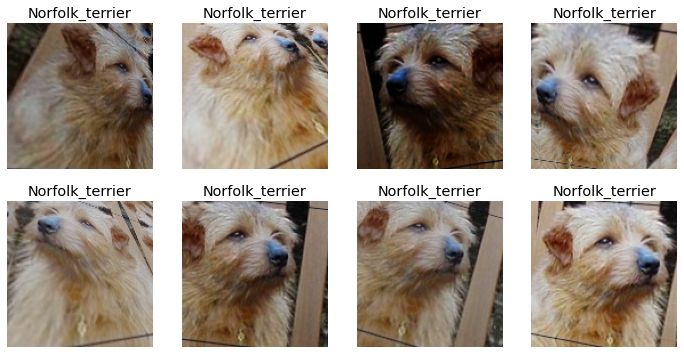

In [37]:
dog_dl_aug = dog_dl.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dog_dat_aug = dog_dl_aug.dataloaders(data_path)
dog_dat_aug.train.show_batch(max_n=8, nrows=2, unique=True)


Now, Im going to train two models on my two different datasets:

In [39]:
learn = cnn_learner(dog_dat, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/hgamble/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.772494,0.495989,0.204545,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.621145,0.535968,0.198864,00:01
1,0.506734,0.480249,0.181818,00:01
2,0.379046,0.518322,0.204545,00:01
3,0.299295,0.524514,0.193182,00:01


In [40]:
learn_aug = cnn_learner(dog_dat_aug, resnet18, metrics=error_rate)
learn_aug.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.013458,0.549466,0.232955,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.993620,0.429622,0.159091,00:02
1,0.849272,0.393655,0.136364,00:02
2,0.717391,0.404595,0.136364,00:02
3,0.647367,0.405553,0.142045,00:02


So it seems like to get metrics out of a model (like the confusion matrix) I need to create an Interpreter object:

In [45]:
interp = ClassificationInterpretation.from_learner(learn)

Show results shows you for each image, the target class and the predicted class

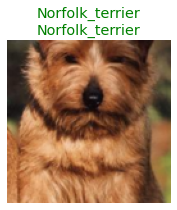

In [49]:
interp.show_results(3)

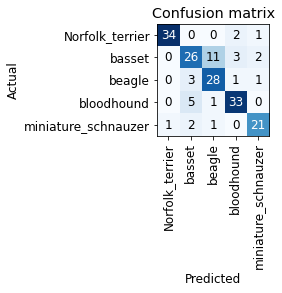

In [50]:
interp.plot_confusion_matrix()

In [51]:
interp.confusion_matrix()

array([[34,  0,  0,  2,  1],
       [ 0, 26, 11,  3,  2],
       [ 0,  3, 28,  1,  1],
       [ 0,  5,  1, 33,  0],
       [ 1,  2,  1,  0, 21]])

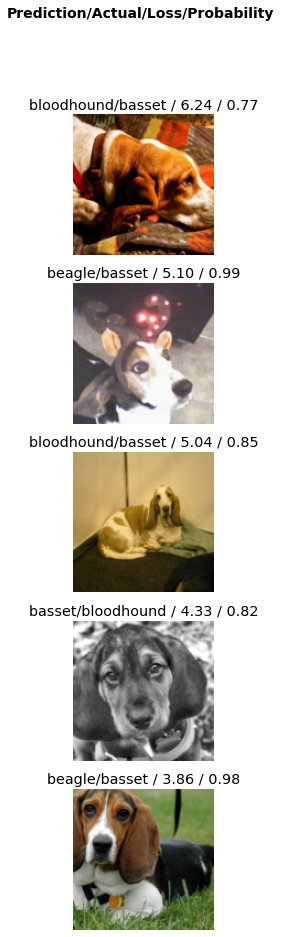

In [55]:
interp.plot_top_losses(5, nrows=5)